In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import timeit
start = timeit.default_timer()

In [73]:
class GMM:
    
    def __init__(self, k = 3, eps = 0.00000001):
        self.k = k 
        self.eps = eps 
        from collections import namedtuple
    
    def fit_EM(self, X, max_iters = 10000000):
        n, d = X.shape
        mean=X[np.random.choice(n, self.k, False), :]
        cov= [np.eye(d)] * self.k
        
        w = [1./self.k] * self.k
               
        R = np.zeros((n, self.k))
        
        
        log_likelihoods = []
        association=[]
        
        P = lambda mu, s: np.linalg.det(s) ** -.5 ** (2 * np.pi) ** (-X.shape[1]/2.) \
                * np.exp(-.5 * np.einsum('ij, ij -> i',\
                        X - mu, np.dot(np.linalg.inv(s) , (X - mu).T).T ) ) 
                        
        
        while len(log_likelihoods) < max_iters:
            
            # E - Step
            for k in range(self.k):
                R[:, k] = w[k] * P(mean[k], cov[k])
            log_likelihood = np.sum(np.log(np.sum(R, axis = 1)))
            log_likelihoods.append(log_likelihood)
            R = (R.T / np.sum(R, axis = 1)).T
            N_ks = np.sum(R, axis = 0)
            # M Step
            for k in range(self.k):
             
                mean[k] = 1. / N_ks[k] * np.sum(R[:, k] * X.T, axis = 1).T
                x_mu = np.matrix(X - mean[k])
                
                cov[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mu.T,  R[:, k]), x_mu))
                
                w[k] = 1. / n * N_ks[k]

            if len(log_likelihoods) < 2 : continue
            if np.abs(log_likelihood - log_likelihoods[-2]) < self.eps: break
        #store set of attributes as a tuple    
        from collections import namedtuple
        self.params = namedtuple('params', ['mean', 'cov', 'w', 'log_likelihoods', 'num_iters'])
        self.params.mean = mean
        self.params.cov = cov
        self.params.w = w
        self.params.log_likelihoods = log_likelihoods
        self.params.num_iters = len(log_likelihoods)       
        
        return self.params, R


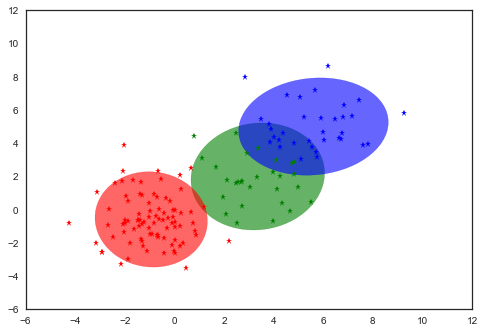

Mean: 
 [[ 3.35741377  1.96713461]
 [-0.93902114 -0.61874782]
 [ 5.60271472  4.97227307]]
Amplitude: 
 [0.20845687615777933, 0.5772073840651949, 0.21433573977702569]
Covariance matrix: 
 [array([[ 1.81287284,  0.13858336],
       [ 0.13858336,  2.59528293]]), array([[ 1.28240216, -0.06401456],
       [-0.06401456,  2.05699187]]), array([[ 2.27470509,  0.19882186],
       [ 0.19882186,  2.1440437 ]])]
0.7999367928129573


In [74]:
def applyGMM():
    # Load data
    X = np.loadtxt('clusters.txt',delimiter=',')
    data1=np.array(X[0:50])
    data2=np.array(X[50:100])
    data3=np.array(X[100:150])
    
    X = np.vstack((data1,np.vstack((data2,data3))))
    np.random.shuffle(X)
    gmm = GMM(3, 0.00000000001)
    params,R = gmm.fit_EM(X, max_iters= 100000000000)
    return X, params,R


    
def plot_ellipse(pos, cov, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
    if ax is None:
        ax = plt.gca()
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
        # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    
    ax.add_artist(ellip)
    return ellip    
def getClusterAssociation(clusterAssociation, data):
    clus0=[]
    clus1=[]
    clus2=[]
    #print('X 5 rows are {}'.format(data[0:5]))
    for i,j in enumerate(clusterAssociation):
        if j==0:
            clus0.append(list(data[i]))
        elif j==1:
            clus1.append(list(data[i]))
        else:
            clus2.append(list(data[i]))
    #print('clus 0 {}'.format(clus0))        
    return clus0, clus1, clus2  
def show(X, mu, cov, R):

    axes = plt.gca()
    axes.set_xlim([-6,12])
    axes.set_ylim([-6,12])
    data1, data2, data3=getClusterAssociation(R, X)
    K = len(mu) 
    colors = ['g', 'r', 'b']
    data1Len=len(data1)
    data2Len=len(data2)
    data3Len=len(data3)
    for i in range(0,data1Len):
        plt.plot(data1[i][0], data1[i][1], 'g*')
    for i in range(0,data2Len):
        plt.plot(data2[i][0], data2[i][1], 'r*')
    for i in range(0,data3Len):
        plt.plot(data3[i][0], data3[i][1], 'b*')    
    
        
    for k in range(K):
        plot_ellipse(mu[k], cov[k],  alpha=0.6, color = colors[k % len(colors)])  
    
    plt.show()    
X, params, R=applyGMM()
R=[list(i) for i in R]
tempR=R
R=[i.index(max(i)) for i in R]
#print(clusterAssc)
show(X,params.mean,params.cov, R)
print('Mean: \n',params.mean)
      
tempR=np.array(tempR)

print('Amplitude: \n',[sum(tempR.T[0])/150,sum(tempR.T[1])/150, sum(tempR.T[2])/150])
print('Covariance matrix: \n',params.cov)

a = timeit.default_timer() - start
print (a)
